## Compare the hyperparameter tuning as done by Robnik et al to a Bayesian Optimization tuning scheme.

For Metropolis Adjusted Hamiltonain Monte Carlo (MAMS) there are two hyperparameters to tune:  
1) stepsize $\epsilon$  
2) trajectory length $L$

A preconditioning matrix $M$ is also commonly used to transform the position-momentum space.

Robnik et al dd sequential tuning.  
Here, we will investigate Optimizing over all hyperparameters at once using Bayesian Optimization.

In [45]:
# Load libraries






# Imports from here: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12 # Changed from 19 to 12

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(548)


# Imports for Adjusted MCLMC (MAMS):
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm


# Imports for NUTS:
import jax.scipy.stats as stats





# JAX guide: https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html
# Blackjax guide: https://blackjax-devs.github.io/sampling-book/




# Bayes Opt for JAX
# Boax guide: https://boax.readthedocs.io/en/latest/index.html
from boax.experiments import optimization


# Make JAX work
from jax import config
config.update("jax_enable_x64", True)

# Time the experiments
import time

# Use ARVIZ for MCMC diagnostics 
# See: https://python.arviz.org/en/stable/api/diagnostics.html
import arviz as az
import xarray as xr







In [6]:
# Set all the seeds

# For tuning the algorithms
SEED_NUTS_TUNING = 548
SEED_MCLMC_TUNING = 548
SEED_MAMS_TUNING = 548

# When testing the algorithms
SEED_BAYESOPT_VALIDATION = 2025
SEED_AUTO_VALIDATION = 2025

In [7]:
# Make Neal's funnel
def make_funnel_logdensity(dim):
    def logdensity(x):
        log_prob = -0.5 * (x[0]**2 / 9.0)
        log_prob += -0.5 * (dim - 1) * x[0]
        log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
        return log_prob
    return logdensity

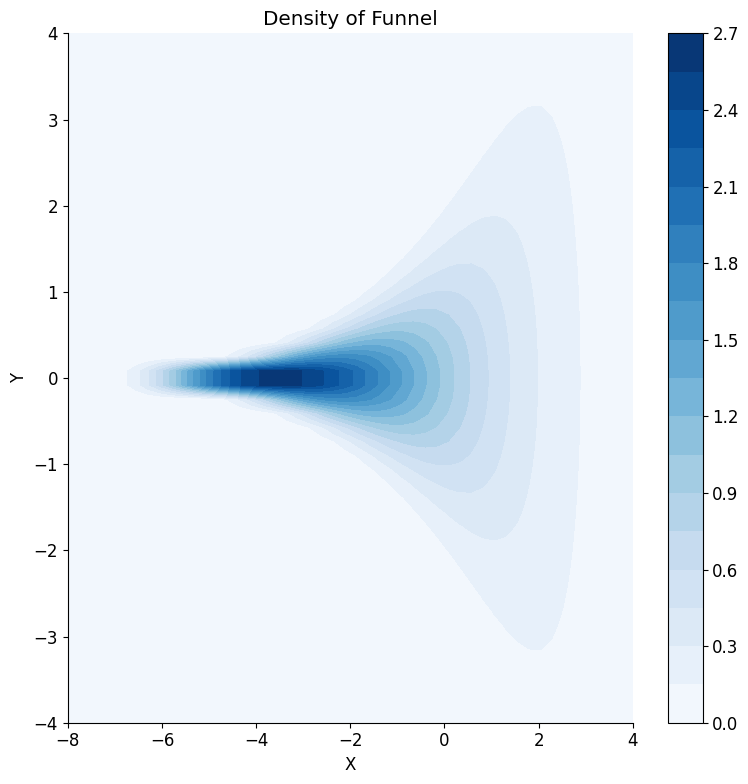

In [27]:
# Plot the funnel in 2d
logdensity = make_funnel_logdensity(dim = 2)

# Make grid
x = np.linspace(-8, 4, 50)
y = np.linspace(-4, 4, 50)
X, Y = np.meshgrid(x, y)

# Fill grid with log densities
flat = np.stack([X.ravel(), Y.ravel()], axis=1)
Z = np.array([logdensity(jnp.array(x)) for x in flat]).reshape(X.shape)

# exp(log density) = density
prob_density = np.exp(Z)

# Make plot
fig, ax = plt.subplots(figsize=(8,8))
contours = ax.contourf(
    X, 
    Y, 
    prob_density,
    levels = 20,
    cmap = 'Blues'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density of Funnel')
plt.colorbar(contours, ax = ax)
plt.tight_layout()
plt.show()

In [41]:
# Make ESS function
def compute_ess(samples):
    
    # Transpose it so it runs
    samples_reshaped = samples.T[:, None, :] 
    # Find ESS for each dimension
    ess_per_dim = jax.vmap(lambda x: blackjax.diagnostics.effective_sample_size(x), in_axes = 0)(samples_reshaped)
    
    # Return the ESS from the dimension with the lowest/min ESS
    return jnp.min(ess_per_dim)

# ess(data, *[, var_names, method, relative, ...])

In [ ]:
# Make R-hat function
def compute_rhat(chains):
    num_chains, num_steps, dim = chains.shape
    chain_means = jnp.mean(chains, axis=1)
    overall_mean = jnp.mean(chain_means, axis=0)
    B = num_steps / (num_chains - 1) * jnp.sum((chain_means - overall_mean)**2, axis=0)
    chain_vars = jnp.var(chains, axis=1, ddof=1)
    W = jnp.mean(chain_vars, axis=0)
    var_est = ((num_steps - 1) / num_steps) * W + (1 / num_steps) * B
    rhat = jnp.sqrt(var_est / W)
    return rhat

# rhat(data, *[, var_names, method, dask_kwargs])



In [ ]:
# Use NUTS with fixed hyperparameters
# This is for canonical dynamics
# Do a chain of NUTS

# See: https://blackjax-devs.github.io/blackjax/examples/quickstart.html#nuts


def run_nuts_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    step_size, 
    inv_mass_matrix):
    
    # Start timing
    start_time = time.time()
    
    # Use Blackjax NUTS
    nuts = blackjax.nuts(logdensity_fn, step_size, inv_mass_matrix)
    
    # Input the given position
    state = nuts.init(initial_position)
    
    # Do proposal step in NUTS
    def one_step(state, key):
        state, info = nuts.step(key, state)
        return state, (state.position, info.acceptance_rate, info.num_integration_steps)
    
    # Need a seed for each NUTS trajectory
    keys = jax.random.split(key, chain_length)
    
    # Do a chain of NUTS
    final_state, (samples, acceptance_rates, num_steps_per_iter) = jax.lax.scan(one_step, state, keys)
    
    # Stats for this NUTS chain
    avg_acceptance = jnp.mean(acceptance_rates)
    ess = compute_ess(samples)
    avg_integration_steps = jnp.mean(num_steps_per_iter)
    time_elapsed = time.time() - start_time
    
    # Return stats
    return samples, ess, avg_acceptance, avg_integration_steps, time_elapsed

In [50]:
# Use MCLMC (no Metropolis accept/reject step) with fixed hyperparameters
# Microcanonical dynamics
# Need to tune L and step_size

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

def run_mclmc_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    L,
    step_size
    ):
    
    # Time the chain
    start_time = time.time()
    
    # Reproducible
    init_key, run_key = jax.random.split(key)
    
    # Fix a starting point
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, 
        logdensity_fn=logdensity_fn, 
        rng_key=init_key
    )
    
    # Make a MCLMC sampler
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L = L,
        step_size = step_size,
    )
    
    # Save results from the algorithm
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key = run_key, # consistent results
        initial_state = initial_state, # start same place 
        inference_algorithm = sampling_alg, # 
        num_steps = chain_length,
        transform = lambda state, _: state.position,
        progress_bar = True,
    )
    
    # Stats on the chain
    ess = compute_ess(samples)
    avg_acceptance = 1 # MCLMC does not reject
    integration_steps_per_iter = L / step_size
    time_elapsed = time.time() - start_time
    
    return samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed


Average acceptance: 1
Effective sample size: 40.6327450947059
Integration steps per iteration: 20.0
Time elapsed: 0.5259051322937012
First 5 samples:
 [[0.03768003 0.99270236]
 [0.24630992 1.93693324]
 [1.16284069 2.11373761]
 [1.94365584 1.50760266]
 [2.4836785  0.68836377]]


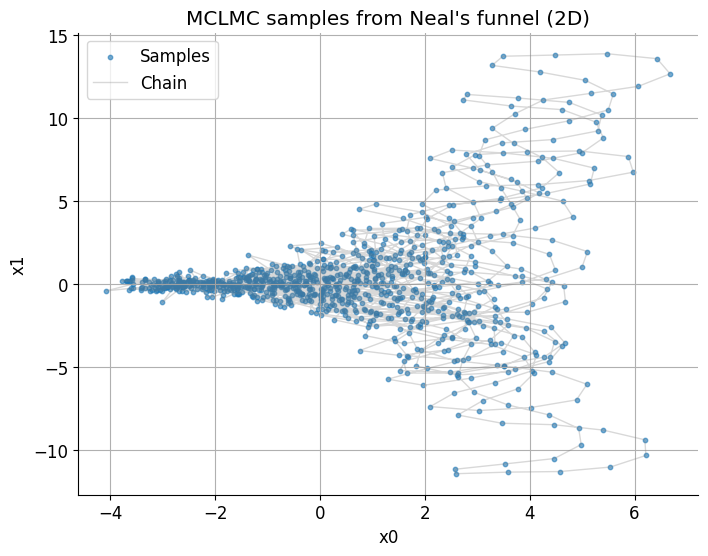

array([<Axes: title={'center': 'x0\n0'}>,
       <Axes: title={'center': 'x1\n0'}>], dtype=object)

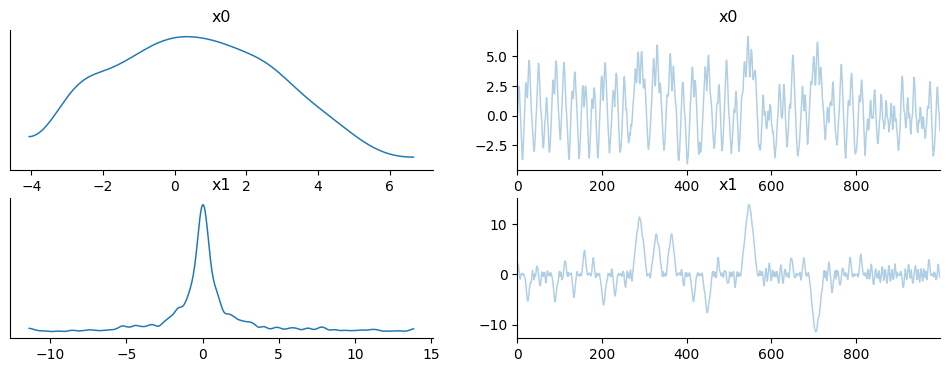

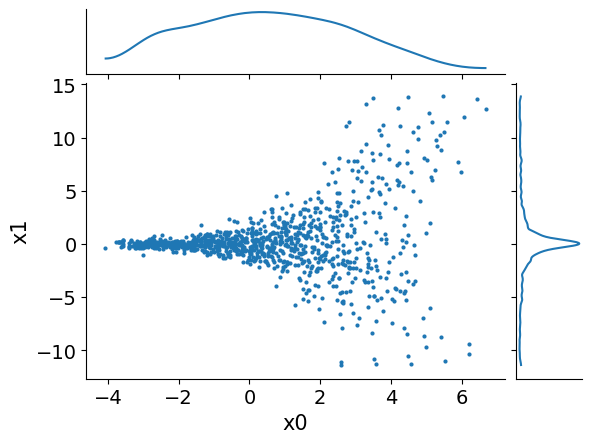

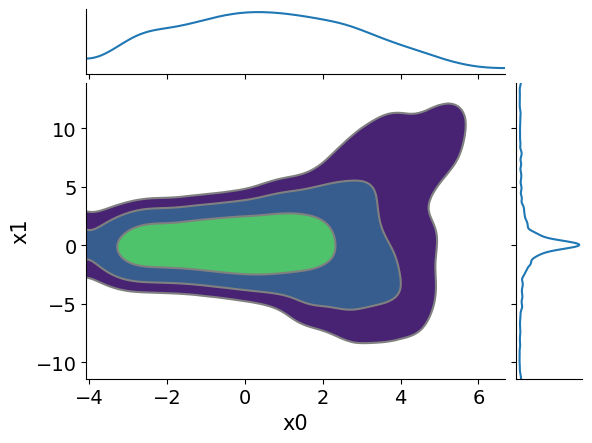

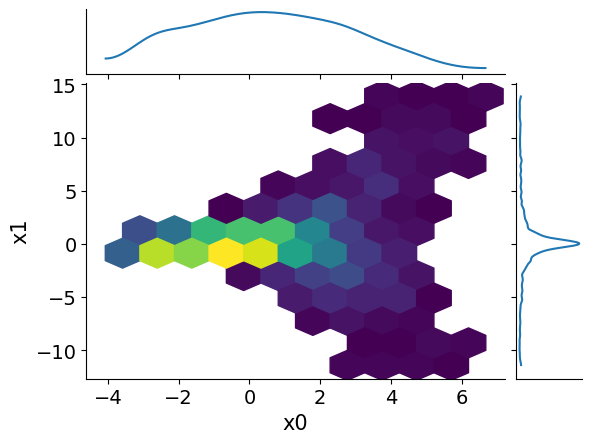

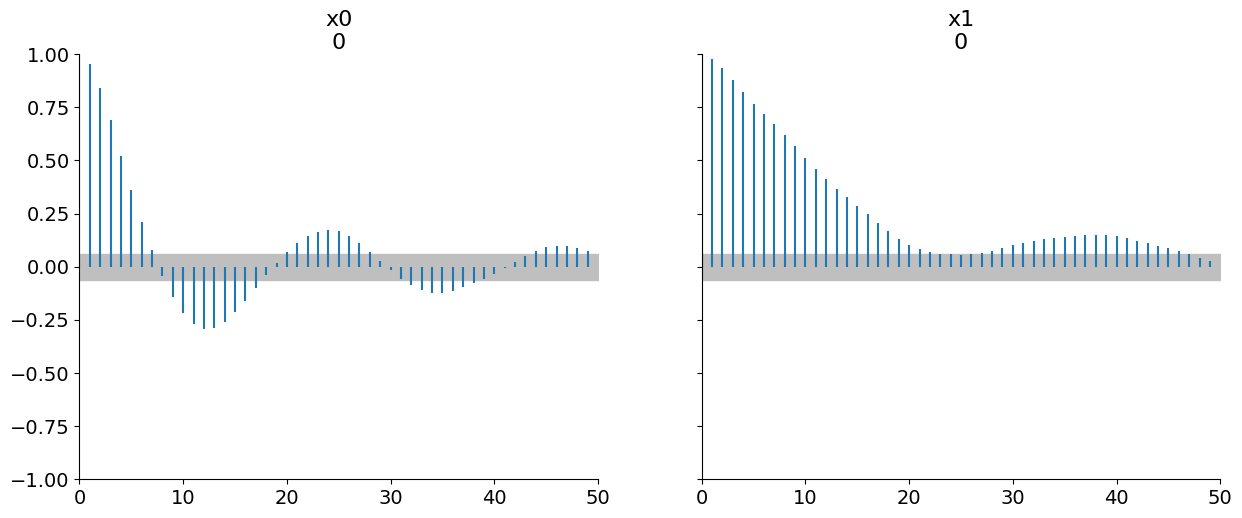

In [57]:
# Try out MCLMC

logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
L = 20.0
step_size = 1

samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed = run_mclmc_fixed(
    logdensity_fn=logdensity,
    chain_length=chain_length,
    initial_position=initial_position,
    key=key,
    L=L,
    step_size=step_size
)

print("Average acceptance:", avg_acceptance)
print("Effective sample size:", ess)
print("Integration steps per iteration:", integration_steps_per_iter)
print("Time elapsed:", time_elapsed)
print("First 5 samples:\n", samples[:5])



# samples.shape = (chain_length, 2)
x0 = samples[:, 0]
x1 = samples[:, 1]

plt.figure(figsize=(8,6))

# Scatter of samples
plt.scatter(x0, x1, s=10, alpha=0.6, label='Samples')

# Optional: connect samples in order to see the chain trajectory
plt.plot(x0, x1, color='gray', alpha=0.3, linewidth=1, label='Chain')

plt.xlabel('x0')
plt.ylabel('x1')
plt.title('MCLMC samples from Neal\'s funnel (2D)')
plt.legend()
plt.grid(True)
plt.show()


# Suppose `samples` is a numpy/jax array of shape (chain_length, 2)
# Create an InferenceData object
idata = az.from_dict(
    posterior={
        "x0": samples[:, 0],
        "x1": samples[:, 1],
    }
)
az.plot_trace(idata, var_names=["x0", "x1"])
az.plot_pair(idata, var_names=["x0", "x1"], kind="scatter", marginals=True)
# KDE pair plot
az.plot_pair(idata, var_names=["x0", "x1"], kind="kde", marginals=True)

# Hexbin pair plot
az.plot_pair(idata, var_names=["x0", "x1"], kind="hexbin", marginals=True)

az.plot_autocorr(idata, var_names=["x0", "x1"], max_lag=50)


In [52]:
# Metropolis adjusted Microcanonical HMC
# Need to tune L and step size

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc

def run_mams_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    L, 
    step_size):
    
    # Time the chain
    start_time = time.time()
    
    # Same results everytime, 
    # Key for 1) initialize the sampler, 2) run the chain
    init_key, run_key = jax.random.split(key)
    
    # Setup the MAMS
    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position = initial_position,
        logdensity_fn = logdensity_fn,
        random_generator_arg = init_key,
    )
    
    # Sampling 
    algorithm = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn = logdensity_fn, # Target log density
        step_size = step_size, # For leapfrog
        integration_steps_fn = lambda key: jnp.ceil(L / step_size), # Blackjax needs a key even for fixed L
        L_proposal_factor = jnp.inf, # Fixed L
    )
    
    # One iteration to get one sample if accepted
    def one_step(state, key):
        state, info = algorithm.step(key, state)
        return state, (state.position, info.acceptance_rate)
    
    # A seed for each sample in chain length
    keys = jax.random.split(run_key, chain_length)
    
    # Run a chain
    final_state, (samples, acceptance_rates) = jax.lax.scan(one_step, initial_state, keys)
    
    # Stats on the chain
    avg_acceptance = jnp.mean(acceptance_rates)
    ess = compute_ess(samples)
    integration_steps_per_iter = L / step_size
    time_elapsed = time.time() - start_time
    
    
    return samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed


Average acceptance: 0.9864875379303126
Effective sample size: 19.167666345215366
Integration steps per iteration: 10.0
Time elapsed: 0.6756141185760498
First 5 samples:
 [[ 0.28469159 -0.95471381]
 [ 0.94622818 -0.22370936]
 [ 1.94583633 -0.24894634]
 [ 1.18691609  0.38896669]
 [ 1.50406225  1.32774868]]


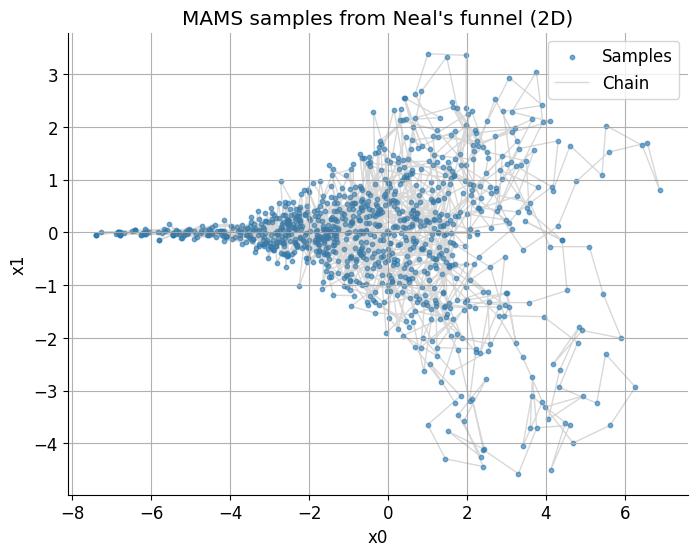

array([<Axes: title={'center': 'x0\n0'}>,
       <Axes: title={'center': 'x1\n0'}>], dtype=object)

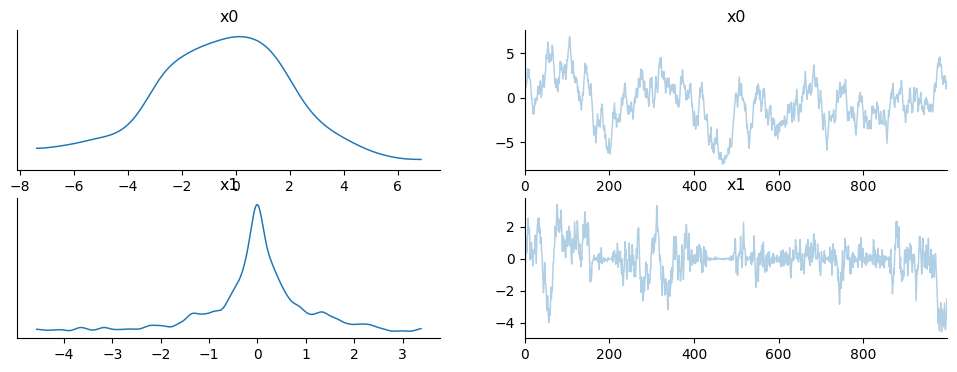

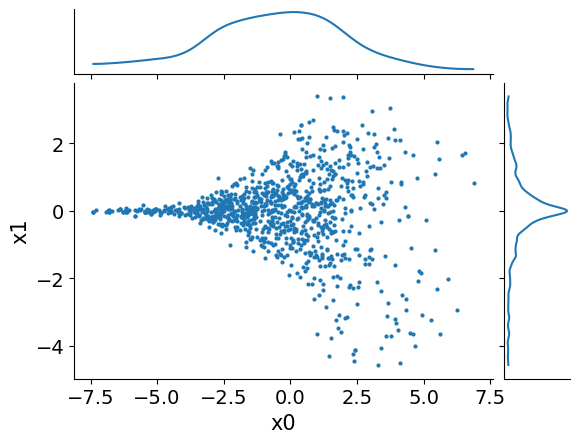

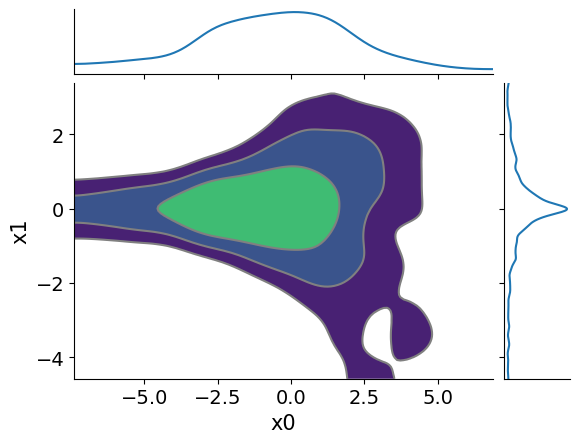

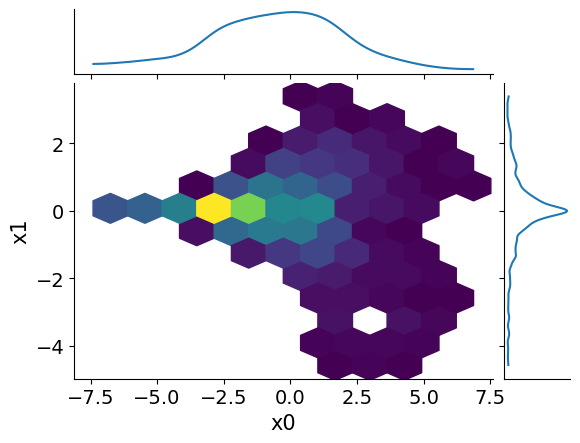

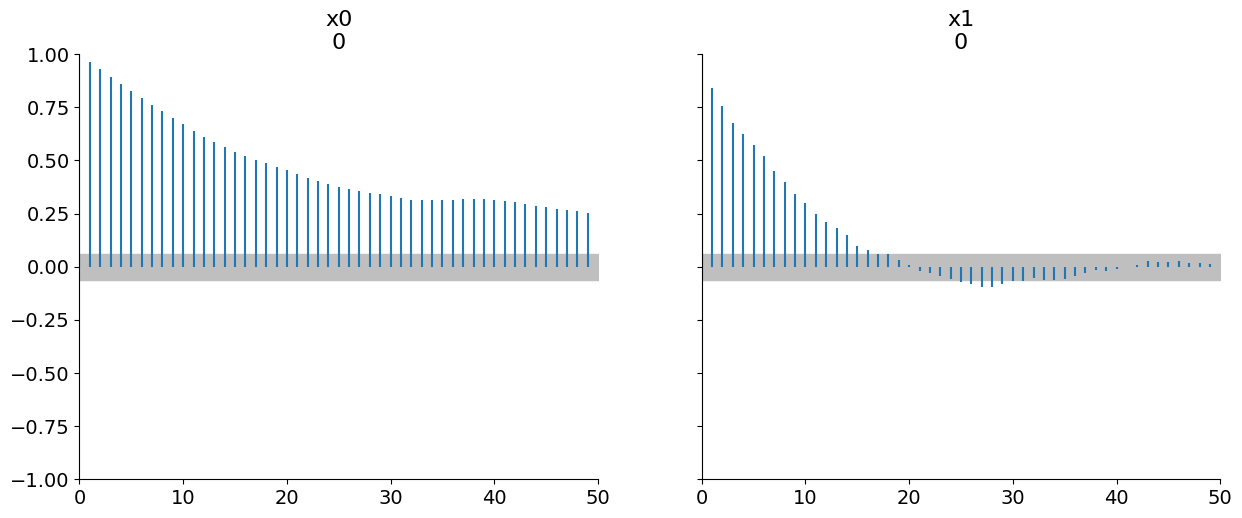

In [53]:
# Try out MAMS

logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
L = 1.0
step_size = 0.1

samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed = run_mams_fixed(
    logdensity_fn=logdensity,
    chain_length=chain_length,
    initial_position=initial_position,
    key=key,
    L=L,
    step_size=step_size
)

print("Average acceptance:", avg_acceptance)
print("Effective sample size:", ess)
print("Integration steps per iteration:", integration_steps_per_iter)
print("Time elapsed:", time_elapsed)
print("First 5 samples:\n", samples[:5])



# samples.shape = (chain_length, 2)
x0 = samples[:, 0]
x1 = samples[:, 1]

plt.figure(figsize=(8,6))

# Scatter of samples
plt.scatter(x0, x1, s=10, alpha=0.6, label='Samples')

# Optional: connect samples in order to see the chain trajectory
plt.plot(x0, x1, color='gray', alpha=0.3, linewidth=1, label='Chain')

plt.xlabel('x0')
plt.ylabel('x1')
plt.title('MAMS samples from Neal\'s funnel (2D)')
plt.legend()
plt.grid(True)
plt.show()


# Suppose `samples` is a numpy/jax array of shape (chain_length, 2)
# Create an InferenceData object
idata = az.from_dict(
    posterior={
        "x0": samples[:, 0],
        "x1": samples[:, 1],
    }
)
az.plot_trace(idata, var_names=["x0", "x1"])
az.plot_pair(idata, var_names=["x0", "x1"], kind="scatter", marginals=True)
# KDE pair plot
az.plot_pair(idata, var_names=["x0", "x1"], kind="kde", marginals=True)

# Hexbin pair plot
az.plot_pair(idata, var_names=["x0", "x1"], kind="hexbin", marginals=True)

az.plot_autocorr(idata, var_names=["x0", "x1"], max_lag=50)


In [54]:
# Bayes opt them

# Objective function 
def objective_function(ess, acceptance_rate, target_acceptance, lambda_penalty, 
                       integration_steps_per_iter=None, normalize_by_cost=False):
    """
    Compute objective for hyperparameter optimization.
    
    Args:
        ess: Effective Sample Size
        acceptance_rate: Average acceptance rate
        target_acceptance: Desired acceptance rate
        lambda_penalty: Penalty weight for acceptance deviation
        integration_steps_per_iter: Number of integration steps per MCMC iteration
        normalize_by_cost: If True, use ESS/n; if False, use raw ESS
    
    Returns:
        Objective value to maximize
    """
    if normalize_by_cost and integration_steps_per_iter is not None:
        # ESS per integration step (fair comparison across different L, ε)
        ess_normalized = ess / integration_steps_per_iter
    else:
        # Raw ESS (for NUTS where L is adaptive)
        ess_normalized = ess
    
    penalty = lambda_penalty * (acceptance_rate - target_acceptance)**2
    return ess_normalized - penalty


def run_bayesopt_tuning(
    logdensity_fn,
    initial_position,
    fixed_key,
    algorithm_name,
    num_iterations=20,
    chain_length=1000,
    target_acceptance=0.65,
    lambda_penalty=100.0,
):
    """Use Bayesian optimization to find optimal hyperparameters."""
    results = {
        'iteration': [],
        'ess': [],
        'ess_per_step': [],
        'ess_per_second': [],
        'acceptance_rate': [],
        'objective': [],
        'integration_steps': [],
        'hyperparams': [],
        'time_per_eval': [],
    }
    
    start_time = time.time()
    
    # Define search space and evaluation function
    if algorithm_name == 'NUTS':
        parameters = [{'name': 'log_step_size', 'type': 'log_range', 'bounds': [1e-5, 1e-1]}]
        
        def run_with_params(params_dict):
            step_size = params_dict['log_step_size']
            inv_mass_matrix = jnp.ones(len(initial_position))
            _, ess, acc, avg_n, eval_time = run_nuts_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, step_size, inv_mass_matrix
            )
            return ess, acc, avg_n, eval_time
        
        normalize_by_cost = False  # NUTS has adaptive L
        
    elif algorithm_name == 'MCLMC':
        parameters = [
            {'name': 'L', 'type': 'log_range', 'bounds': [1e-1, 1e2]},
            {'name': 'step_size', 'type': 'log_range', 'bounds': [1e-3, 1.0]}
        ]
        target_acceptance = 1.0
        
        def run_with_params(params_dict):
            L, step_size = params_dict['L'], params_dict['step_size']
            _, ess, acc, n, eval_time = run_mclmc_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        normalize_by_cost = True  # Fair comparison needed
        
    elif algorithm_name == 'MAMS':
        parameters = [
            {'name': 'L', 'type': 'log_range', 'bounds': [1e-1, 1e2]},
            {'name': 'step_size', 'type': 'log_range', 'bounds': [1e-3, 1.0]}
        ]
        target_acceptance = 0.9
        
        def run_with_params(params_dict):
            L, step_size = params_dict['L'], params_dict['step_size']
            _, ess, acc, n, eval_time = run_mams_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        normalize_by_cost = True  # Fair comparison needed
    
    # Initialize BOAx experiment
    experiment = optimization(parameters=parameters, batch_size=1)
    
    # Run optimization loop
    step, experiment_results = None, []
    
    for i in range(num_iterations):
        print(f"Iteration {i+1}/{num_iterations}")
        
        step, parameterizations = experiment.next(step, experiment_results)
        params_dict = parameterizations[0]
        
        ess, acc, n, eval_time = run_with_params(params_dict)
        
        # Compute normalized metrics
        ess_per_step = ess / n if n > 0 else 0
        ess_per_second = ess / eval_time if eval_time > 0 else 0
        
        # Compute objective (normalized or not)
        obj = objective_function(ess, acc, target_acceptance, lambda_penalty, 
                                n, normalize_by_cost)
        
        experiment_results = [(params_dict, float(obj))]
        
        results['iteration'].append(i)
        results['ess'].append(float(ess))
        results['ess_per_step'].append(float(ess_per_step))
        results['ess_per_second'].append(float(ess_per_second))
        results['acceptance_rate'].append(float(acc))
        results['objective'].append(float(obj))
        results['integration_steps'].append(float(n))
        results['hyperparams'].append(params_dict)
        results['time_per_eval'].append(eval_time)
        
        print(f"  {algorithm_name}: ESS={ess:.1f}, ESS/n={ess_per_step:.4f}, "
              f"ESS/s={ess_per_second:.1f}, n={n:.1f}")
    
    total_time = time.time() - start_time
    
    best_idx = jnp.argmax(jnp.array(results['objective']))
    best_params = results['hyperparams'][best_idx]
    
    print(f"\n{algorithm_name} Best:")
    print(f"  Params: {best_params}")
    print(f"  ESS: {results['ess'][best_idx]:.1f}")
    print(f"  ESS/n: {results['ess_per_step'][best_idx]:.4f}")
    print(f"  ESS/s: {results['ess_per_second'][best_idx]:.1f}")
    
    return results
